In [1]:
!pip install numpy pandas matplotlib tqdm

In [6]:
import os
import pandas as pd
import numpy as np

In [3]:
# ONLY FOR COLAB
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set base directory (main project directory in Google Drive)
BASE_DIR = "/content/drive/My Drive/Energy_prediction"

# Check if the path is correct
print(f"Base directory set to: {BASE_DIR}")

Mounted at /content/drive
Base directory set to: /content/drive/My Drive/Energy_prediction


In [7]:
#local
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname("__file__"), "..",".."))

In [8]:
# Set path to the data file
data_path = os.path.join(BASE_DIR, "data", "processed", "energy_consumption_aggregated_cleaned_proto.csv")

print("Data path:", data_path)  # Check if the path is correct

Data path: C:\Users\Anwender\Desktop\Projects\Energy_prediction\data\processed\energy_consumption_aggregated_cleaned_proto.csv


In [9]:
df = pd.read_csv(data_path)
df1 = df #store for date column for plots
df.head(-1)

,date,consumption_MW,temperature_c,hour_sin,hour_cos,weekday_sin,weekday_cos,rolling_mean_6h,month_sin,month_cos,consumption_last_week,consumption_yesterday,consumption_last_hour
0,2011-01-09 00:00:00,120110,-6.75,0.000000,1.000000,-0.781831,0.623490,128378.333333,0.500000,0.866025,117780.0,127240.0,126070.0
1,2011-01-09 01:00:00,114690,-7.25,0.258819,0.965926,-0.781831,0.623490,125473.333333,0.500000,0.866025,111990.0,120440.0,120110.0
2,2011-01-09 02:00:00,109360,-7.85,0.500000,0.866025,-0.781831,0.623490,121706.666667,0.500000,0.866025,106820.0,114940.0,114690.0
3,2011-01-09 03:00:00,106340,-8.08,0.707107,0.707107,-0.781831,0.623490,117590.000000,0.500000,0.866025,103760.0,112180.0,109360.0
4,2011-01-09 04:00:00,105310,-8.95,0.866025,0.500000,-0.781831,0.623490,113646.666667,0.500000,0.866025,102470.0,110350.0,106340.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66296,2018-08-02 19:00:00,168970,30.05,-0.965926,0.258819,0.433884,-0.900969,167511.666667,-0.866025,-0.500000,152440.0,155690.0,170680.0
66297,2018-08-02 20:00:00,164370,29.45,-0.866025,0.500000,0.433884,-0.900969,168116.666667,-0.866025,-0.500000,145790.0,151220.0,168970.0
66298,2018-08-02 21:00:00,155900,29.18,-0.707107,0.707107,0.433884,-0.900969,166460.000000,-0.866025,-0.500000,139450.0,144490.0,164370.0
66299,2018-08-02 22:00:00,150860,29.45,-0.500000,0.866025,0.433884,-0.900969,163488.333333,-0.866025,-0.500000,136260.0,142460.0,155900.0


In [10]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# Entferne die Spalte "date", weil wir schon Zeitfeatures haben
df = df.drop(columns=["date"])

# Features und Target definieren --> entferne is_weekend, kein impact
features = ["hour_sin", "hour_cos", "weekday_sin",	"weekday_cos",	"rolling_mean_6h",	"month_sin",	"month_cos",	"temperature_c",	"consumption_last_week",	"consumption_yesterday",	"consumption_last_hour"]
target = "consumption_MW"

# Zeitbasierter Train-Valid-Test-Split (70% Train, 10% Valid, 20% Test)
train_size = int(len(df) * 0.7)  # 70% für Training
valid_size = int(len(df) * 0.1)  # 10% für Validierung
test_size = len(df) - train_size - valid_size  # 20% für Test

df_train = df.iloc[:train_size]
df_valid = df.iloc[train_size:train_size + valid_size]
df_test = df.iloc[train_size + valid_size:]

X_train, y_train = df_train[features], df_train[target]
X_valid, y_valid = df_valid[features], df_valid[target]
X_test, y_test = df_test[features], df_test[target]

# LightGBM-Datasets erstellen
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)  # Validation hinzufügen
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Ausgabe zur Kontrolle
print(f"Trainingsdaten: {X_train.shape}, Validierungsdaten: {X_valid.shape}, Testdaten: {X_test.shape}")


Trainingsdaten: (46411, 11), Validierungsdaten: (6630, 11), Testdaten: (13261, 11)


In [11]:
import lightgbm as lgb

# Features (alle Spalten außer der Zielvariable)
X_train_lgb = X_train.copy()
y_train_lgb = y_train.copy()

# LightGBM Dataset erstellen
train_data = lgb.Dataset(X_train_lgb, label=y_train_lgb)

# Struktur und erste 5 Einträge ausgeben
print("LightGBM Dataset Struktur:")
print(train_data)

# Feature-Namen ausgeben
print("\nFeature-Namen:")
print(train_data.feature_name)

# Erste paar Zeilen der Feature-Matrix
print("\nErste 5 Einträge im Dataset:")
print(X_train_lgb.head())

# Zielvariable prüfen
print("\nErste 5 Werte der Zielvariable:")
print(y_train_lgb.head())


LightGBM Dataset Struktur:

Feature-Namen:
auto

Erste 5 Einträge im Dataset:
   hour_sin  hour_cos  weekday_sin  weekday_cos  rolling_mean_6h  month_sin  \
0  0.000000  1.000000    -0.781831      0.62349    128378.333333        0.5   
1  0.258819  0.965926    -0.781831      0.62349    125473.333333        0.5   
2  0.500000  0.866025    -0.781831      0.62349    121706.666667        0.5   
3  0.707107  0.707107    -0.781831      0.62349    117590.000000        0.5   
4  0.866025  0.500000    -0.781831      0.62349    113646.666667        0.5   

   month_cos  temperature_c  consumption_last_week  consumption_yesterday  \
0   0.866025          -6.75               117780.0               127240.0   
1   0.866025          -7.25               111990.0               120440.0   
2   0.866025          -7.85               106820.0               114940.0   
3   0.866025          -8.08               103760.0               112180.0   
4   0.866025          -8.95               102470.0            

In [12]:
#overfitting? use noise test; if these are classifeid as important: overfitting
import numpy as np

# Zufallsfeature (gleich verteilt, ohne Bezug zum Ziel)
X_train["noise_feature"] = np.random.rand(len(X_train))
X_valid["noise_feature"] = np.random.rand(len(X_valid))
X_test["noise_feature"] = np.random.rand(len(X_test))  # falls du test später brauchst



**Hyperparameter Tuning**

In [14]:
from lightgbm import LGBMRegressor, early_stopping, record_evaluation
import pandas as pd
import numpy as np
from itertools import product

results = []

# === Grid mit erweitertem Parameter ===
param_grid = {
    'num_leaves': [15, 31],
    'max_depth': [5, 8],
    'learning_rate': [0.05, 0.1],
    'lambda_l1': [0, 1.0],
    'lambda_l2': [0, 1.0],
    'min_split_gain': [0.0, 0.01]  # Hier neu!
}

param_combos = list(product(*param_grid.values()))

for i, combo in enumerate(param_combos):
    params = dict(zip(param_grid.keys(), combo))
    print(f"\nConfig {i+1}/{len(param_combos)}: {params}")

    eval_result = {}

    model = LGBMRegressor(
        objective='regression',
        n_estimators=1000,
        **params,
        verbosity=-1
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(50),
            record_evaluation(eval_result)
        ]
    )

    # Vorhersage
    y_pred = model.predict(X_test)
    mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1e-10, y_test))) * 100

    # Overfit-Gap: RMSE Train vs Val
    train_rmse = eval_result['training']['rmse'][-1]
    valid_rmse = eval_result['valid_1']['rmse'][-1]
    overfit_gap = valid_rmse - train_rmse

    # === Feature Importance ===
    feature_importances = model.feature_importances_
    feature_names = X_train.columns
    importance_dict = dict(zip(feature_names, feature_importances))
    noise_importance = importance_dict.get("noise_feature", 0)

    results.append({
        **params,
        'MAPE': round(mape, 4),
        'Train_RMSE': round(train_rmse, 4),
        'Valid_RMSE': round(valid_rmse, 4),
        'Overfit_Gap': round(overfit_gap, 4),
        'Best_Iteration': model.best_iteration_,
        'Noise_Importance': noise_importance
    })





Config 1/64: {'num_leaves': 15, 'max_depth': 5, 'learning_rate': 0.05, 'lambda_l1': 0, 'lambda_l2': 0, 'min_split_gain': 0.0}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 1218.43	training's l2: 1.48456e+06	valid_1's rmse: 1548.41	valid_1's l2: 2.39758e+06

Config 2/64: {'num_leaves': 15, 'max_depth': 5, 'learning_rate': 0.05, 'lambda_l1': 0, 'lambda_l2': 0, 'min_split_gain': 0.01}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 1218.43	training's l2: 1.48456e+06	valid_1's rmse: 1548.41	valid_1's l2: 2.39758e+06

Config 3/64: {'num_leaves': 15, 'max_depth': 5, 'learning_rate': 0.05, 'lambda_l1': 0, 'lambda_l2': 1.0, 'min_split_gain': 0.0}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 1219.33	training's l2: 1.48677e+06	valid_1's rm

In [15]:

# In DataFrame speichern & sortieren
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by=["Noise_Importance", "MAPE"])

df_results

,num_leaves,max_depth,learning_rate,lambda_l1,lambda_l2,min_split_gain,MAPE,Train_RMSE,Valid_RMSE,Overfit_Gap,Best_Iteration,Noise_Importance
4,15,5,0.05,1.0,0.0,0.00,0.8407,1220.8735,1551.4402,330.5666,1000,295
5,15,5,0.05,1.0,0.0,0.01,0.8407,1220.8735,1551.4402,330.5666,1000,295
0,15,5,0.05,0.0,0.0,0.00,0.8395,1218.4267,1548.4131,329.9863,1000,311
1,15,5,0.05,0.0,0.0,0.01,0.8395,1218.4267,1548.4131,329.9863,1000,311
2,15,5,0.05,0.0,1.0,0.00,0.8405,1219.3335,1540.1682,320.8346,1000,345
...,...,...,...,...,...,...,...,...,...,...,...,...
51,31,8,0.05,0.0,1.0,0.01,0.7914,992.6750,1490.4354,497.7604,995,1678
60,31,8,0.10,1.0,0.0,0.00,0.7796,827.1167,1465.6188,638.5021,869,1891
61,31,8,0.10,1.0,0.0,0.01,0.7796,827.1167,1465.6188,638.5021,869,1891
56,31,8,0.10,0.0,0.0,0.00,0.7858,823.1958,1482.0584,658.8626,879,1926


In [17]:
import os

save_dir = os.path.join(BASE_DIR, "notebooks", "lightgbm")
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "lightgbm_gridsearch_results.csv")
df_results.to_csv(save_path, index=False)

print(f"Grid-Search-Ergebnisse gespeichert unter: {save_path}")

Grid-Search-Ergebnisse gespeichert unter: C:\Users\Anwender\Desktop\Projects\Energy_prediction\notebooks\lightgbm\lightgbm_gridsearch_results.csv


**Best Model**

Safest model idx = 4

In [31]:
# Wähle den Index (z. B. 44 für Modell Nr. 45)
idx = 4
row = df_results.loc[idx]

# Extrahiere die relevanten Hyperparameter
params = {
    "learning_rate": row["learning_rate"],
    "num_leaves": int(row["num_leaves"]),
    "max_depth": int(row["max_depth"]),
    "lambda_l1": row["lambda_l1"],
    "lambda_l2": row["lambda_l2"],
    "min_split_gain": row.get("min_split_gain", 0.01),  # falls vorhanden
    "n_estimators": 1000,
    "objective": "regression"
}

In [32]:
params

{'learning_rate': 0.05,
 'num_leaves': 15,
 'max_depth': 5,
 'lambda_l1': 1.0,
 'lambda_l2': 0.0,
 'min_split_gain': 0.0,
 'n_estimators': 1000,
 'objective': 'regression'}

In [33]:
from lightgbm import LGBMRegressor, early_stopping, record_evaluation


eval_result = {}

model = LGBMRegressor(**params)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(50),
        record_evaluation(eval_result)
    ]
)


[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1603
[LightGBM] [Info] Number of data points in the train set: 46411, number of used features: 12
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Info] Start tr

LGBMRegressor(lambda_l1=1.0, lambda_l2=0.0, learning_rate=0.05, max_depth=5,
              n_estimators=1000, num_leaves=15, objective='regression')

Plot gespeichert unter: notebooks\lightgbm\temp_results\lightgbm_learning_curve.png


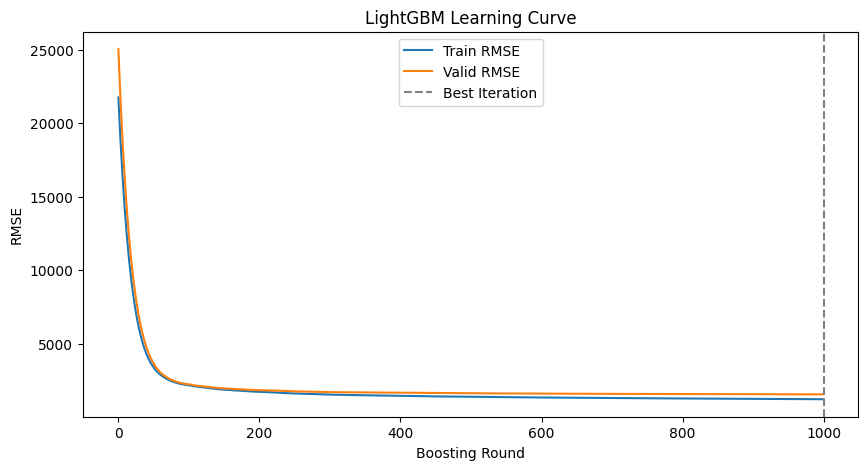

In [34]:
import matplotlib.pyplot as plt
import os

# Ergebnis-Ordner
TEMP_RESULTS_DIR = os.path.join("notebooks", "lightgbm", "temp_results")
os.makedirs(TEMP_RESULTS_DIR, exist_ok=True)  # Falls Ordner noch nicht existiert

train_rmse = eval_result['training']['rmse']
valid_rmse = eval_result['valid_1']['rmse']

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(valid_rmse, label='Valid RMSE')
plt.axvline(model.best_iteration_, color='gray', linestyle='--', label='Best Iteration')
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("LightGBM Learning Curve")
plt.legend()

# Speichern
plot_path = os.path.join(TEMP_RESULTS_DIR, "lightgbm_learning_curve.png")
plt.savefig(plot_path)
print(f"Plot gespeichert unter: {plot_path}")

# Optional anzeigen
plt.show()



In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Vorhersage auf dem finalen Testset
y_pred = model.predict(X_test)

# Metriken berechnen
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Für MAPE: sichere Division
y_test_safe = np.where(y_test == 0, 1e-10, y_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test_safe)) * 100

# Ausgabe
print(f"Test MAPE: {mape:.5f} %")
print(f"Test MAE: {mae:.5f}")
print(f"Test RMSE: {rmse:.5f}")


[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
Test MAPE: 0.84066 %
Test MAE: 968.12042
Test RMSE: 1388.11996


In [36]:
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(feature_importance)

                  Feature  Importance
10  consumption_last_hour        2210
1                hour_cos        2143
0                hour_sin        1888
7           temperature_c        1534
4         rolling_mean_6h        1246
9   consumption_yesterday        1190
8   consumption_last_week        1035
6               month_cos         762
2             weekday_sin         700
5               month_sin         519
3             weekday_cos         406
11          noise_feature         295


Plot gespeichert unter: notebooks\lightgbm\temp_results\lightgbm_feature_importance.png


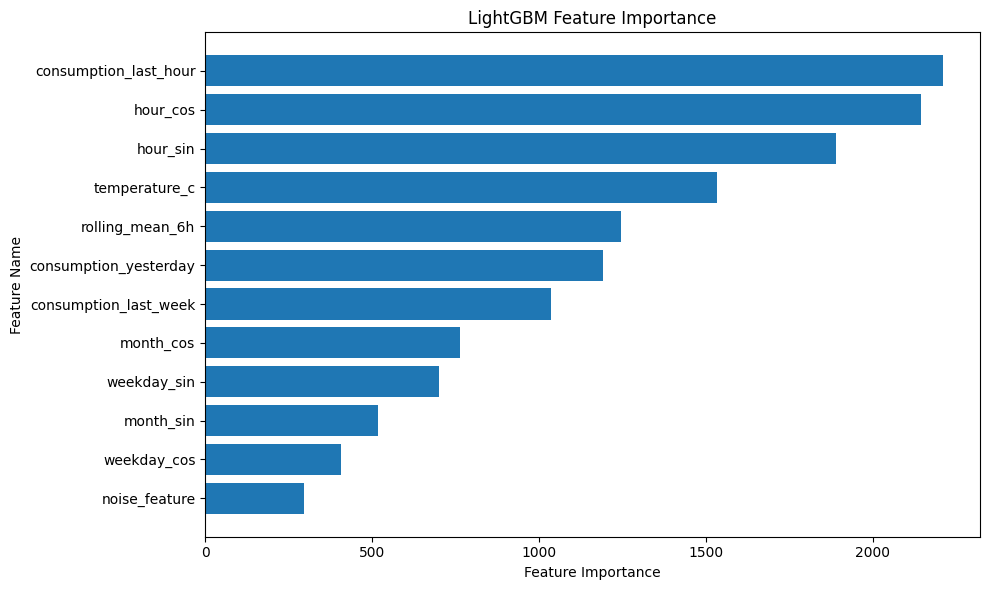

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()

# Speichern
plot_path = os.path.join(TEMP_RESULTS_DIR, "lightgbm_feature_importance.png")
plt.savefig(plot_path)
print(f"Plot gespeichert unter: {plot_path}")

# Optional anzeigen
plt.show()

In [ ]:
!pip install shap

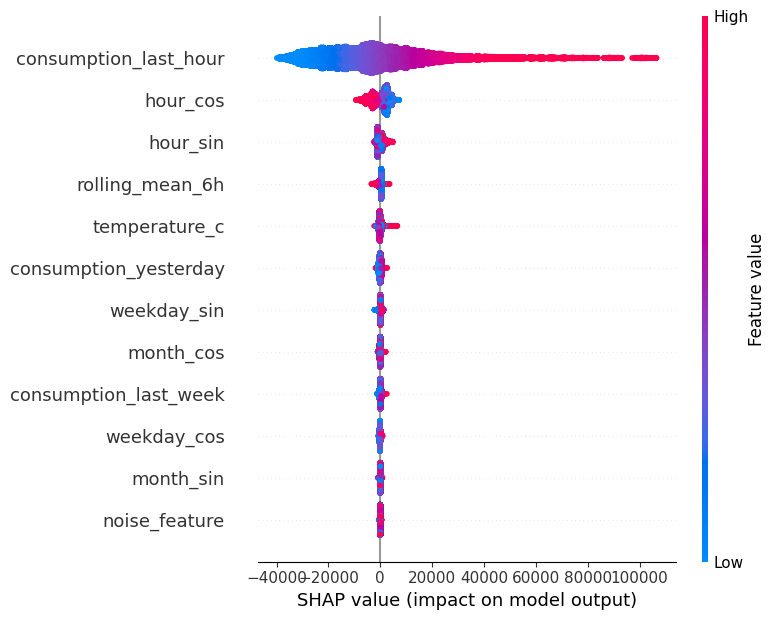

In [40]:
import shap

# SHAP initialisieren
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Summary Plot
shap.summary_plot(shap_values, X_train)


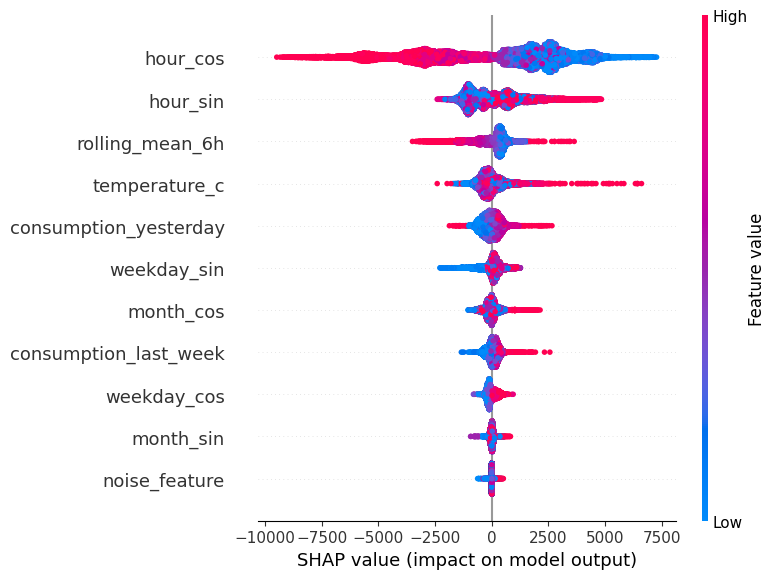

In [41]:
#plot without best feature for better overview

# Alle SHAP-Werte und Feature-Namen außer "consumption_last_hour"
feature_names = X_train.columns.tolist()
filtered_index = feature_names.index("consumption_last_hour")

# Filter SHAP values (entferne die entsprechende Spalte)
shap_values_filtered = np.delete(shap_values, filtered_index, axis=1)
X_filtered = X_train.drop(columns=["consumption_last_hour"])

# Plot neu ohne "consumption_last_hour"
shap.summary_plot(shap_values_filtered, X_filtered)


In [93]:
# DataFrame mit den Ergebnissen erstellen
results_df = pd.DataFrame({
    "True Consumption (MW)": y_test.values,
    "Predicted Consumption (MW)": y_pred
})

# Die ersten paar Werte ausgeben
print(results_df.head(10))

   True Consumption (MW)  Predicted Consumption (MW)
0                 126100               125478.160657
1                 127770               125897.293739
2                 128730               127475.585319
3                 128510               127735.260918
4                 127730               127668.970248
5                 127650               126619.247908
6                 127490               126288.385049
7                 127520               127129.620404
8                 129540               130877.564948
9                 133510               135096.747243


In [95]:
# Korrekte Test-Timestamps extrahieren
test_start = train_size + valid_size
test_dates = df1.iloc[test_start:]["date"].reset_index(drop=True)

# Anhängen an Results-DF
results_df["Timestamp"] = pd.to_datetime(test_dates)

Plot gespeichert unter: notebooks\lightgbm\temp_results\lightgbm_comparison_plot.png


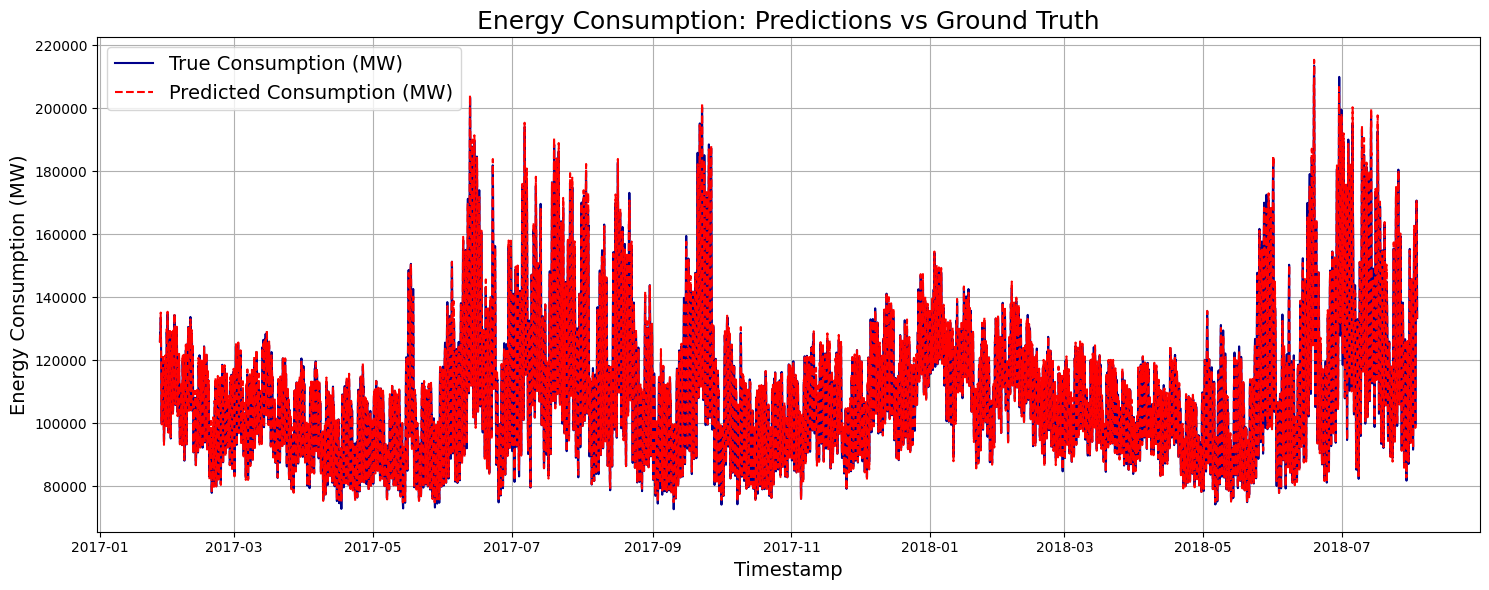

In [96]:
import matplotlib.pyplot as plt
import os

plt.figure(figsize=(15, 6))
plt.plot(results_df["Timestamp"], results_df["True Consumption (MW)"], label="True Consumption (MW)", color="darkblue")
plt.plot(results_df["Timestamp"], results_df["Predicted Consumption (MW)"], label="Predicted Consumption (MW)", color="red", linestyle="--")

plt.title("Energy Consumption: Predictions vs Ground Truth", fontsize=18)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("Energy Consumption (MW)", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()

# Speichern
plot_path = os.path.join(TEMP_RESULTS_DIR, "lightgbm_comparison_plot.png")
plt.savefig(plot_path)
print(f"Plot gespeichert unter: {plot_path}")

plt.show()


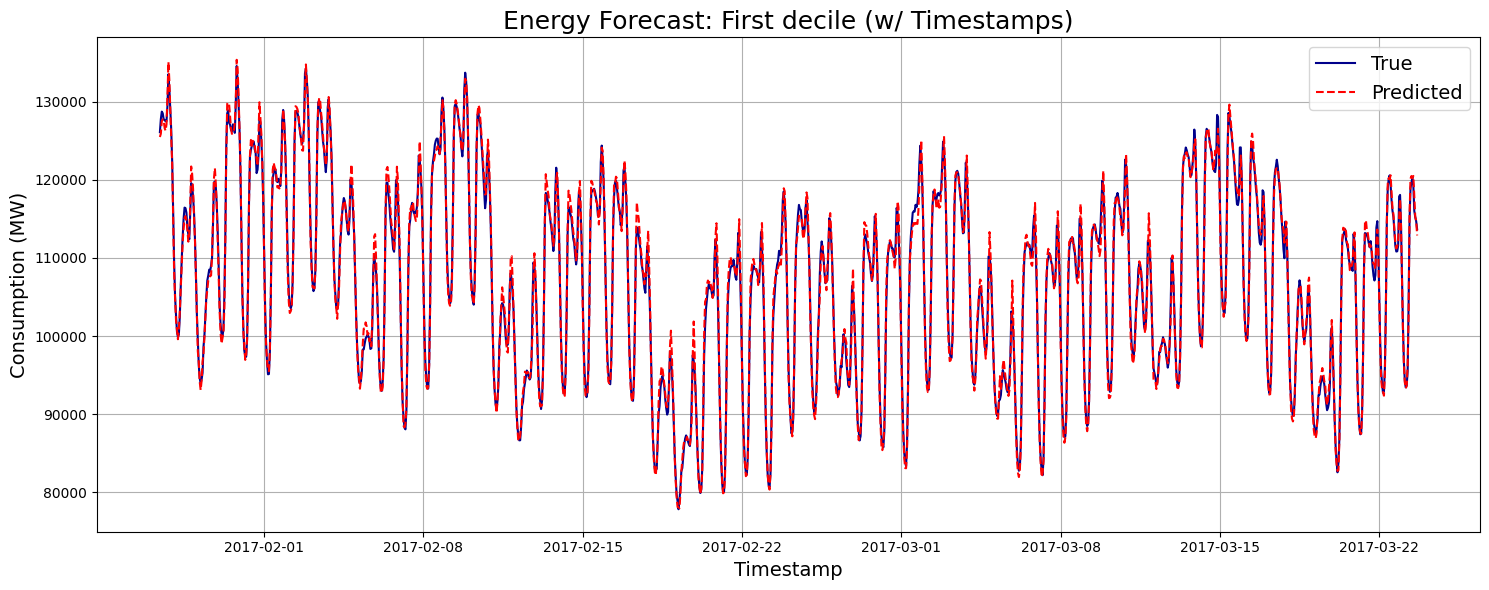

In [97]:
# Wähle nur das erste Zehntel der Daten
df_subset = results_df.iloc[:len(results_df) // 10]

plt.figure(figsize=(15, 6))
plt.plot(df_subset["Timestamp"], df_subset["True Consumption (MW)"], label="True", color="darkblue")
plt.plot(df_subset["Timestamp"], df_subset["Predicted Consumption (MW)"], label="Predicted", color="red", linestyle="--")

plt.title("Energy Forecast: First decile (w/ Timestamps)", fontsize=18)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("Consumption (MW)", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()

# Speichern
plot_path = os.path.join(TEMP_RESULTS_DIR, "lightgbm_prediction_with_timestamp.png")
plt.savefig(plot_path)
plt.show()



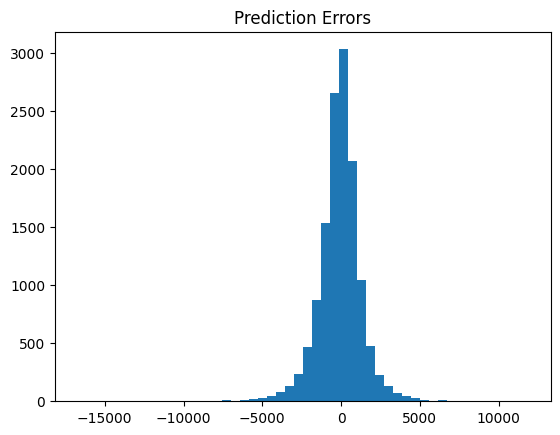

In [98]:
errors = y_test - y_pred
plt.hist(errors, bins=50)
plt.title("Prediction Errors")
plt.show()
 #normal distribution -> again seems like no overfitting

In [99]:
#again overfitting test: --> no overfitting
# Beispiel: letzte 30 Tage rausnehmen
last_month = df.tail(24 * 30)
X_last = last_month[features]
X_last["noise_feature"] = np.random.rand(len(X_last))
y_last = last_month[target]

y_pred_last = model.predict(X_last)

from sklearn.metrics import mean_absolute_error
print("MAPE auf 'neuem' Zeitraum:", np.mean(np.abs((y_last - y_pred_last) / y_last)) * 100)


[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
MAPE auf 'neuem' Zeitraum: 0.9635705458524083
